In [1]:
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 169.98 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54524,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 169.98 GiB
Comm: tcp://127.0.0.1:54553,Total threads: 4
Dashboard: http://127.0.0.1:54559/status,Memory: 28.33 GiB
Nanny: tcp://127.0.0.1:54527,


In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
from ptufile import PtuFile
import tifffile
import dask
from tqdm import tqdm

In [4]:
ptu_dir = Path(
    r'Z:\zmbstaff\9309\Raw_Data\240531_Inhibitor_screening_1\ptu_exports2\data.sptw'
)
export_dir_ptus = Path(
    r'Z:\zmbstaff\9309\Raw_Data\240531_Inhibitor_screening_1\ome_tiffs'
)

fn_IRF_xlsx = Path(
    r'Z:\zmbstaff\9309\Raw_Data\240531_Inhibitor_screening_1\IRF\export_IRF_data.xlsx'
)
export_dir_IRF = Path(
    r'Z:\zmbstaff\9309\Raw_Data\240531_Inhibitor_screening_1\IRF'
)

## Convert ptus to ome-tiff

In [5]:
# make export directory:
os.makedirs(export_dir_ptus, exist_ok=True)

# find ptu files
fns = list(ptu_dir.glob("*.ptu"))

In [6]:
# function to convert ptu to ome-tiff

@dask.delayed
def convert(fn):
    ptu = PtuFile(fn)
    assert ptu.dims == ('T', 'Y', 'X', 'C', 'H')

    # DETERMINE DATA WITHIN PULSE
    time = ptu.coords['H']
    # determine timepoints within pulse (1/repetition rate)
    last = np.where(time <= 1/ptu.frequency)[0][-1]
    # NOTE: logically one would take last+1 at this point, but somehow the data
    # looks more continuous this way. The last timepoint within the pulse
    # somehow has fewer photons, so we leave it out.

    # LOAD DECAY-IMAGES
    # sum all time-accumulations
    flim_img = ptu[...,:last].sum(axis=0).astype('uint16')
    
    # SAVE AS OME-TIFF
    # TODO: add FLIM-metadata
    # get flim-img into correct shape (make sure it matches mask!)
    data = np.transpose(flim_img, (3,2,1,0))
    data = np.flip(data, axis=3)
    save_name = export_dir_ptus / (fn.name.split('.')[0] + '.ome.tif')
    with tifffile.TiffWriter(save_name, bigtiff=True) as tif:
        metadata = {
            'axes': 'TCYX',
            'SignificantBits': 16,
            #'TimeIncrement': 0.1,
            #'TimeIncrementUnit': 's',
            #'PhysicalSizeX': pixelsize,
            #'PhysicalSizeXUnit': 'µm',
            #'PhysicalSizeY': pixelsize,
            #'PhysicalSizeYUnit': 'µm',
            #'Channel': {'Name': ['Channel 1', 'Channel 2']},
            #'Plane': {'PositionX': [0.0] * 16, 'PositionXUnit': ['µm'] * 16},
            }
        options = dict(
            photometric='minisblack',
        )
        tif.write(
            data,
            metadata=metadata,
            **options,
        )
    
    # RETURN TOTAL DECAY FOR QUALITY CONTROL
    time_cropped = time[:last].copy()
    decay = flim_img.astype('uint32').sum(axis=(0,1,2))
    
    return time_cropped, decay, ptu.frequency

In [7]:
# convert files in parallel
outputs_delayed = [convert(fn) for fn in fns]
outputs = dask.compute(*outputs_delayed)

# extract some data
times = [o[0] for o in outputs]
decays = [o[1] for o in outputs]
frequencies = [o[2] for o in outputs]

In [8]:
# check if data is consistent between files
for time, frequency in zip(times, frequencies):
    if not np.allclose(time, times[0]):
        print("WARNING: timepoints are not consistent between files")
    if frequency != frequencies[0]:
        print("WARNING: frequencies are not consistent between files")

## Combine exported IRFs

In [9]:
# LOAD IRF DATA
# read IRFs
df = pd.read_excel(fn_IRF_xlsx, header=[0, 1])

# extract IRF columns
columns = df.columns.get_level_values(0).unique()
columns = columns[columns.str.contains('IRF')]

# extract IRF data
irf_data = []
for column in columns:
    time = df[column].iloc[:, 0].dropna().to_numpy()
    irf = df[column].iloc[:, 1].dropna().to_numpy()
    irf_data.append(np.array([time, irf]))

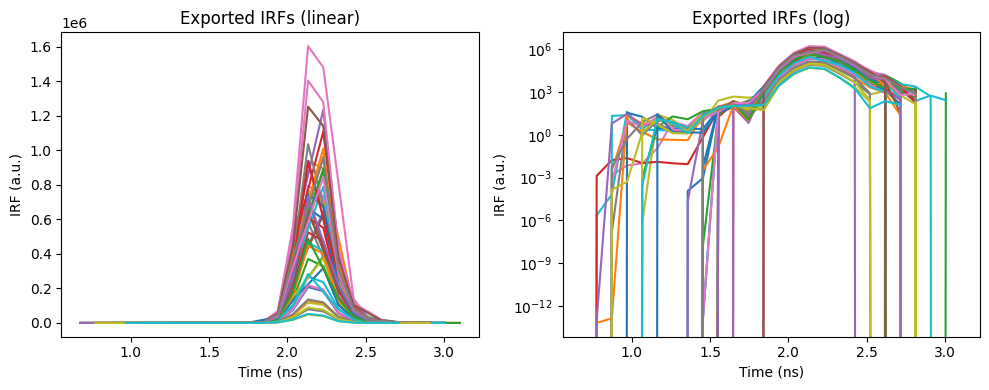

In [10]:
# plot raw IRFs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for data in irf_data:
    time, irf = data
    irf_normalized = irf
    ax1.plot(time, irf_normalized)
    ax2.semilogy(time, irf_normalized)

ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('IRF (a.u.)')
ax1.set_title('Exported IRFs (linear)')

ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('IRF (a.u.)')
ax2.set_title('Exported IRFs (log)')

plt.tight_layout()

In [11]:
# COMBINE IRFs
# interpolate IRFs to match FLIM data
irf_data_interp = []
IRF_time = times[0] * 10**9 # time from FLIM data in ns
for data in irf_data:
    interp = interpolate.CubicSpline(data[0], data[1], extrapolate=0)
    data_interp = np.nan_to_num(interp(IRF_time), nan=0)
    irf_data_interp.append(np.array([IRF_time, data_interp]))

# normalize IRFs
irf_data_norm = []
irf_data_interp_norm = []
for data, data_interp in zip(irf_data, irf_data_interp):
    #norm = data_interp[1].max()  # normalize to max
    norm = data_interp[1].sum()  # normalize to sum
    irf_data_norm.append(np.array([data[0], data[1] / norm]))
    irf_data_interp_norm.append(np.array([data_interp[0], data_interp[1] / norm]))

# take mean of normalized IRFs
irf_data_interp_norm_mean = np.mean(np.array(irf_data_interp_norm), axis=0)

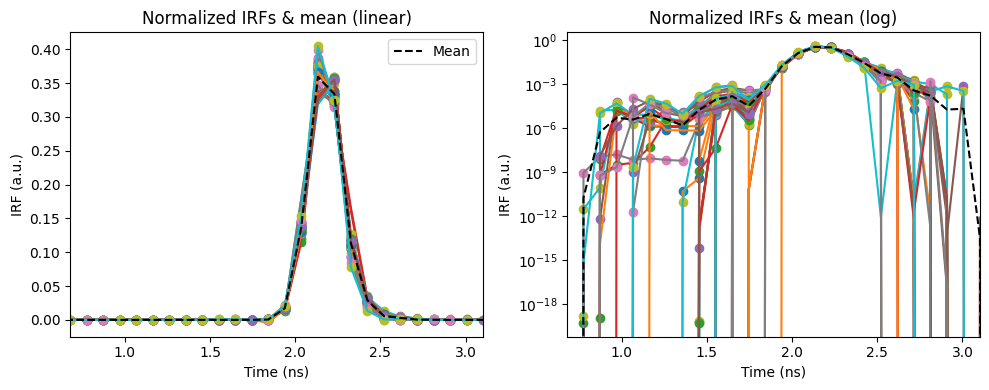

In [12]:
# plot result
xlims = (
    min([min(data[0]) for data in irf_data]),
    max([max(data[0]) for data in irf_data])
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for data, data_interp in zip(irf_data_norm, irf_data_interp_norm):
    ax1.plot(data[0], data[1], 'o')
    ax1.plot(data_interp[0], data_interp[1])

    ax2.semilogy(data[0], data[1], 'o')
    ax2.plot(data_interp[0], data_interp[1])

ax1.plot(irf_data_interp_norm_mean[0], irf_data_interp_norm_mean[1], 'k--', label='Mean')
ax2.plot(irf_data_interp_norm_mean[0], irf_data_interp_norm_mean[1], 'k--')

ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('IRF (a.u.)')
ax1.set_title('Normalized IRFs & mean (linear)')
ax1.legend()

ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('IRF (a.u.)')
ax2.set_title('Normalized IRFs & mean (log)')

ax1.set_xlim(xlims[0], xlims[1])
ax2.set_xlim(xlims[0], xlims[1])
plt.tight_layout()

In [13]:
# export IRF as csv
export_time = (irf_data_interp_norm_mean[0] * 10**3).astype('int')
export_data = irf_data_interp_norm_mean[1] / irf_data_interp_norm_mean[1].max()
irf_df = pd.DataFrame({'t': export_time, 'irf_ch1': export_data})
irf_df.to_csv(export_dir_IRF / 'irf_est.csv', index=False, float_format='%.6f')

## Plots for quality control

In [14]:
print(f"repetition rate is {frequencies[0]/10**6} MHz")

repetition rate is 39.01 MHz


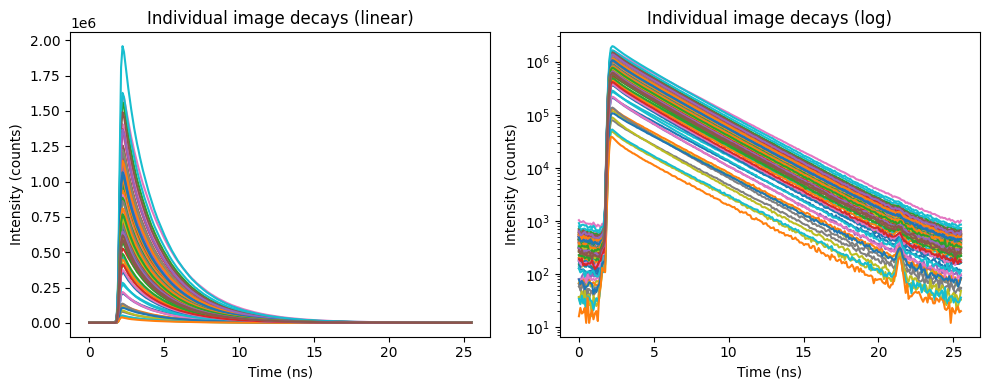

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for time, decay in zip(times, decays):
    ax1.plot(time*10**9, decay)
    ax2.semilogy(time*10**9, decay)

ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Intensity (counts)')
ax1.set_title('Individual image decays (linear)')

ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Intensity (counts)')
ax2.set_title('Individual image decays (log)')

plt.tight_layout()

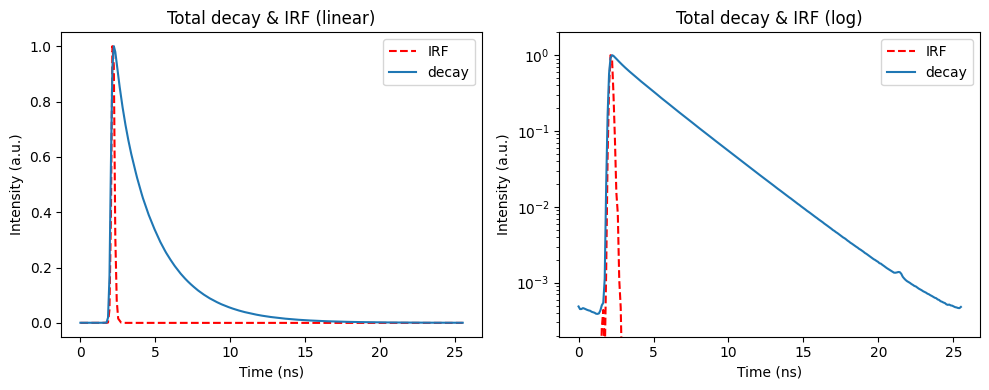

In [16]:
decay = np.array(decays).sum(axis=0)
decay_norm = decay / decay.max()

irf = irf_data_interp_norm_mean[1]
irf_norm = irf / irf.max()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(time*10**9, irf_norm, 'r--', label='IRF')
ax1.plot(time*10**9, decay_norm, label='decay')
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Intensity (a.u.)')
ax1.set_title('Total decay & IRF (linear)')
ax1.legend()

ax2.semilogy(time*10**9, irf_norm, 'r--', label='IRF')
ax2.semilogy(time*10**9, decay_norm, label='decay')
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Intensity (a.u.)')
ax2.set_title('Total decay & IRF (log)')
ax2.legend()
#ax2.set_ylim(decay.min()/10, 1.1)
ax2.set_ylim(decay_norm.min()/2, 2)

plt.tight_layout()

Text(0, 0.5, 'Intensity (counts)')

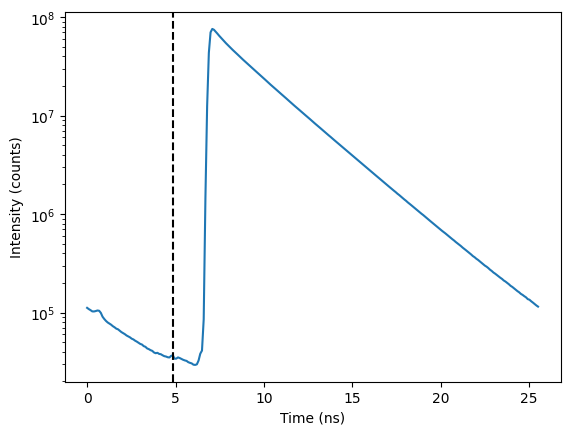

In [17]:
# CHECK IF PERIODICITY MAKES SENSE
time = times[0]
decay = np.array(decays).sum(axis=0)
plt.semilogy(time*10**9, np.roll(decay, 50))
plt.axvline(time[50]*10**9, color='black', linestyle='--')

plt.xlabel('Time (ns)')
plt.ylabel('Intensity (counts)')